# Brief 04 : Est-ce que ce prêt doit être accordé ou rejetté ?

In [31]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer l'IterativeImputer
from sklearn.impute import IterativeImputer

from sklearn.preprocessing import LabelEncoder


In [32]:
df = pd.read_csv("data/SBAnational.csv")
df.columns

C:\Users\asus\AppData\Local\Temp\ipykernel_17300\992082409.py:1: DtypeWarning:

Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.



Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv'],
      dtype='object')

In [33]:
# Afficher le DataFrame nettoyé
df.shape[0]

899164

# Explication des colonnes

### Identification et localisation de l'entreprise

- **LoanNr_ChkDgt** : Numéro unique du prêt   <span style="color:red;">Useless</span>
- **Name** : Nom de l'entreprise bénéficiaire du prêt. <span style="color:red;">Useless</span>
- **City** : Ville où est située l'entreprise.  <span style="color:grey;">Redondant</span>
- **State** : État    <span style="color:green;">OK</span>
- **Zip** : Code postal   <span style="color:grey;">Redondant</span>

# Informations sur les prêts aux entreprises

## Informations sur la banque prêteuse

- **Bank** : Nom de la banque ayant accordé le prêt.  <span style="color:red;">Trop de valeurs uniques</span>
- **BankState** : État où est située la banque prêteuse.  <span style="color:green;">OK</span>

## Informations sur l'entreprise

- **NAICS** : Code de classification de l'industrie.   <span style="color:green;">OK</span>  -200.000 valeurs si not null notNaN
- **NoEmp** : Nombre d'employés de l'entreprise au moment de la demande de prêt.  <span style="color:green;">OK</span>
- **NewExist** : Indique si l'entreprise est nouvelle (**1**) ou existante (**2**). <span style="color:green;">OK</span> 

## Détails du prêt

- **ApprovalDate** : Date à laquelle le prêt a été approuvé.  <span style="color:grey;">redondant</span>
- **ApprovalFY** : Année fiscale d'approbation du prêt <span style="color:green;">OK</span>
- **Term** : Durée du prêt en mois.  <span style="color:green;">OK</span>
- **CreateJob** : Nombre d'emplois que l'entreprise prévoit de créer grâce au prêt.  <span style="color:green;">OK</span>
- **RetainedJob** : Nombre d'emplois que l'entreprise prévoit de conserver grâce au prêt.  <span style="color:green;">OK</span>
- **FranchiseCode** : Code indiquant si l'entreprise est une franchise (**00000** signifie que ce n'est pas une franchise).  <span style="color:green;">OK</span>
- **UrbanRural** : Indique si l'entreprise est située dans une zone **urbaine** (**1**), **rurale** (**2**), ou **non spécifiée** (**0**).  <span style="color:green;">OK</span>

## Conditions du prêt

- **RevLineCr** : Indique si le prêt est une ligne de crédit renouvelable <span style="color:green;">OK</span> 
- **LowDoc** : Indique si le prêt fait partie du programme *Low Documentation* <span style="color:green;">OK</span>

## Informations financières et remboursement

- **ChgOffDate** : Date à laquelle le prêt a été radié en cas de non-remboursement.  <span style="color:red;">Data Leaking</span>
- **DisbursementDate** : Date à laquelle les fonds ont été décaissés.  <span style="color:green;">OK</span>
- **DisbursementGross** : Montant total du prêt accordé.  <span style="color:green;">OK</span>
- **BalanceGross** : Montant restant dû sur le prêt.  <span style="color:red;">Data Leaking</span>
- **MIS_Status** : Statut du prêt :  <span style="color:blue;">TARGET</span>
  - **PIF (Paid In Full)** : Le prêt a été remboursé intégralement.  
  - **CHGOFF (Charged Off)** : Le prêt a été radié (perte pour la banque).  
- **ChgOffPrinGr** : Montant du principal du prêt qui a été radié (perdu par la banque).  <span style="color:red;">useless</span>
- **GrAppv** : Montant total approuvé par la banque.  <span style="color:green;">OK</span>
- **SBA_Appv** : Montant garanti par la *SBA* (une partie du prêt est garantie par l'agence).  <span style="color:green;">OK</span>


In [34]:
# Nombre de zéros
num_zeros = (df["SBA_Appv"] == 0).sum()

# Nombre de valeurs NaN
num_nans = df["SBA_Appv"].isna().sum()
print(num_nans)

print(f"Nombre de zéros : {num_zeros}")
print(f"Nombre de NaN : {num_nans}")

df['SBA_Appv'].describe()
df.info()

0
Nombre de zéros : 0
Nombre de NaN : 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCo

In [35]:
df.head()

LoanNr_ChkDgt                           Name          City State    Zip  \
0     1000014003                 ABC HOBBYCRAFT    EVANSVILLE    IN  47711   
1     1000024006    LANDMARK BAR & GRILLE (THE)     NEW PARIS    IN  46526   
2     1000034009          WHITLOCK DDS, TODD M.   BLOOMINGTON    IN  47401   
3     1000044001  BIG BUCKS PAWN & JEWELRY, LLC  BROKEN ARROW    OK  74012   
4     1000054004    ANASTASIA CONFECTIONS, INC.       ORLANDO    FL  32801   

                            Bank BankState   NAICS ApprovalDate ApprovalFY  \
0               FIFTH THIRD BANK        OH  451120    28-Feb-97       1997   
1                1ST SOURCE BANK        IN  722410    28-Feb-97       1997   
2        GRANT COUNTY STATE BANK        IN  621210    28-Feb-97       1997   
3  1ST NATL BK & TR CO OF BROKEN        OK       0    28-Feb-97       1997   
4        FLORIDA BUS. DEVEL CORP        FL       0    28-Feb-97       1997   

   ...  RevLineCr  LowDoc  ChgOffDate  DisbursementDate  DisbursementGross  \
0  ...          N       Y         NaN         28-Feb-99        $60,000.00    
1  ...          N       Y         NaN         31-May-97        $40,000.00    
2  ...          N       N         NaN         31-Dec-97       $287,000.00    
3  ...          N       Y         NaN         30-Jun-97        $35,000.00    
4  ...          N       N         NaN         14-May-97       $229,000.00    

   BalanceGross  MIS_Status ChgOffPrinGr        GrAppv      SBA_Appv  
0        $0.00        P I F       $0.00    $60,000.00    $48,000.00   
1        $0.00        P I F       $0.00    $40,000.00    $32,000.00   
2        $0.00        P I F       $0.00   $287,000.00   $215,250.00   
3        $0.00        P I F       $0.00    $35,000.00    $28,000.00   
4        $0.00        P I F       $0.00   $229,000.00   $229,000.00   

[5 rows x 27 columns]

In [36]:
df["DisbursementDate"] = pd.to_datetime(df["DisbursementDate"], format="%d-%b-%y")
df["DisbursementDate"].describe() 
print(df["FranchiseCode"])

0         1
1         1
2         1
3         1
4         1
         ..
899159    1
899160    1
899161    1
899162    1
899163    1
Name: FranchiseCode, Length: 899164, dtype: int64


compare 'DisbursementGross', 'GrAppv'

In [37]:
# On supprime les 14 lignes ou State = 0 ou null
# df_clean = df[
#     (df['State'] != 0) & (df['State'].notna()) &
#     (df['BankState'] != 0) & (df['BankState'].notna()) &
#     (df['NoEmp'] != 0) & (df['NoEmp'].notna()) &
#     (df['NewExist'] != 0) & (df['NewExist'].notna())&
#     (df['RetainedJob'].notna()) &
#     (df['CreateJob'].notna()) &
#     (df['UrbanRural'].notna()) &  #useless
#     (df['RevLineCr'].notna())&
#     (df['DisbursementDate'].notna())
# ]
df_clean = df
df_clean['NAICS_2'] = df_clean['NAICS'].astype(str).str[:2]
# df_clean = df_clean[df_clean['NAICS_2'].notna() & (df_clean['NAICS_2'] != '0')]
df_clean["FranchiseCode"] = df["FranchiseCode"].where(df["FranchiseCode"] == 0, 1)
df_clean["RevLineCr"] = df["RevLineCr"].map(lambda x: 0 if x in ["N", "0"] else (1 if x in ["Y", "1"] else np.nan))
df_clean["LowDoc"] = df["LowDoc"].map(lambda x: 0 if x == "N" else (1 if x == "Y" else np.nan))
df_clean["DisbursementDate"] = pd.to_datetime(df["DisbursementDate"], format="%d-%b-%y")

columns_to_keep = [ 'Term','FranchiseCode','State','BankState','NAICS_2', 'NoEmp', 'NewExist', 
                   'RetainedJob', 'CreateJob', 'UrbanRural', 
                   'RevLineCr', 'ApprovalFY', 'DisbursementGross', 'GrAppv',  'LowDoc', 'MIS_Status']

# Vérifier le nombre de lignes après nettoyage
df_clean.shape[0]

899164

In [38]:
df2 = df_clean[columns_to_keep]
df2["MIS_Status"] = df2["MIS_Status"].map(lambda x: 1 if x == "P I F" else (0 if x== "CHGOFF" else np.nan) )
df2['DisbursementGross'] = df['DisbursementGross'].replace('[\$,]', '', regex=True).astype(float)
df2['GrAppv'] = df['GrAppv'].replace('[\$,]', '', regex=True).astype(float)
#df2['SBA_Appv'] = df['SBA_Appv'].replace('[\$,]', '', regex=True).astype(float)
# df2['DisbursementDate'] = df2['DisbursementDate'].astype(str).str[:4]
# df2["DisbursementDate"] = df2["DisbursementDate"].astype(int)
df2['ApprovalFY'] = pd.to_numeric(df2['ApprovalFY'].astype(str).str[:4], errors='coerce').astype('Int64')
#df2 = df2.dropna(subset=['MIS_Status'])

df2.head()

<>:3: SyntaxWarning:

invalid escape sequence '\$'

<>:4: SyntaxWarning:

invalid escape sequence '\$'

<>:3: SyntaxWarning:

invalid escape sequence '\$'

<>:4: SyntaxWarning:

invalid escape sequence '\$'

C:\Users\asus\AppData\Local\Temp\ipykernel_17300\4189958050.py:3: SyntaxWarning:

invalid escape sequence '\$'

C:\Users\asus\AppData\Local\Temp\ipykernel_17300\4189958050.py:4: SyntaxWarning:

invalid escape sequence '\$'

C:\Users\asus\AppData\Local\Temp\ipykernel_17300\4189958050.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\asus\AppData\Local\Temp\ipykernel_17300\4189958050.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Term  FranchiseCode State BankState NAICS_2  NoEmp  NewExist  RetainedJob  \
0    84              1    IN        OH      45      4       2.0            0   
1    60              1    IN        IN      72      2       2.0            0   
2   180              1    IN        IN      62      7       1.0            0   
3    60              1    OK        OK       0      2       1.0            0   
4   240              1    FL        FL       0     14       1.0            7   

   CreateJob  UrbanRural  RevLineCr  ApprovalFY  DisbursementGross    GrAppv  \
0          0           0        0.0        1997            60000.0   60000.0   
1          0           0        0.0        1997            40000.0   40000.0   
2          0           0        0.0        1997           287000.0  287000.0   
3          0           0        0.0        1997            35000.0   35000.0   
4          7           0        0.0        1997           229000.0  229000.0   

   LowDoc  MIS_Status  
0     1.0         1.0  
1     1.0         1.0  
2     0.0         1.0  
3     1.0         1.0  
4     0.0         1.0

In [39]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Term               899164 non-null  int64  
 1   FranchiseCode      899164 non-null  int64  
 2   State              899150 non-null  object 
 3   BankState          897598 non-null  object 
 4   NAICS_2            899164 non-null  object 
 5   NoEmp              899164 non-null  int64  
 6   NewExist           899028 non-null  float64
 7   RetainedJob        899164 non-null  int64  
 8   CreateJob          899164 non-null  int64  
 9   UrbanRural         899164 non-null  int64  
 10  RevLineCr          879310 non-null  float64
 11  ApprovalFY         899164 non-null  Int64  
 12  DisbursementGross  899164 non-null  float64
 13  GrAppv             899164 non-null  float64
 14  LowDoc             893157 non-null  float64
 15  MIS_Status         897167 non-null  float64
dtypes:

- Variable numérique

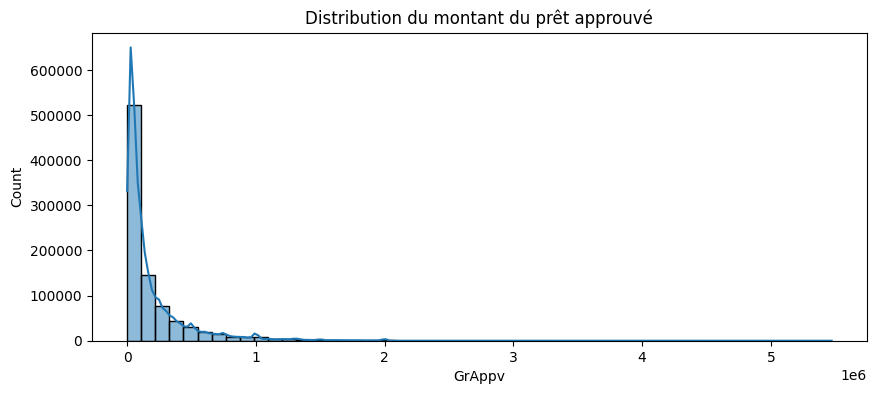

GrAppv  DisbursementGross          NoEmp           Term
count  8.991640e+05       8.991640e+05  899164.000000  899164.000000
mean   1.926870e+05       2.011540e+05      11.411353     110.773078
std    2.832634e+05       2.876408e+05      74.108196      78.857305
min    2.000000e+02       0.000000e+00       0.000000       0.000000
25%    3.500000e+04       4.200000e+04       2.000000      60.000000
50%    9.000000e+04       1.000000e+05       4.000000      84.000000
75%    2.250000e+05       2.380000e+05      10.000000     120.000000
max    5.472000e+06       1.144632e+07    9999.000000     569.000000

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution des montants de prêt
plt.figure(figsize=(10, 4))
sns.histplot(df2['GrAppv'], bins=50, kde=True)
plt.title('Distribution du montant du prêt approuvé')
plt.show()

# Statistiques descriptives
df2[['GrAppv', 'DisbursementGross', 'NoEmp', 'Term']].describe()

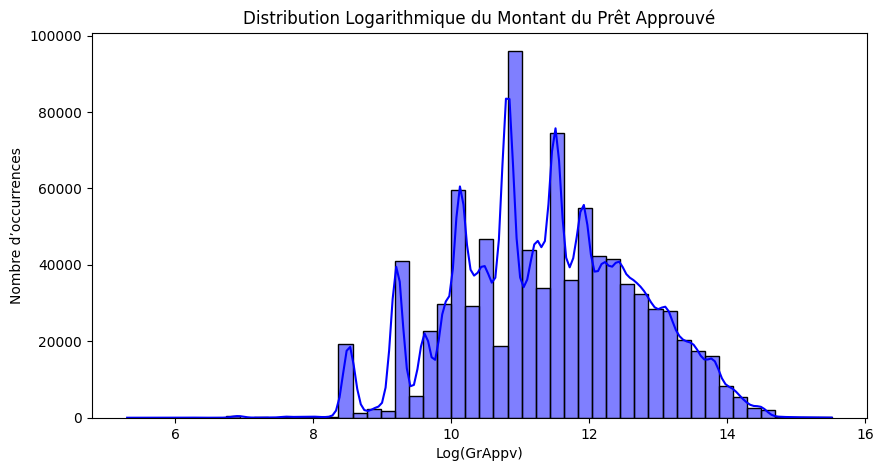

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 5))

# Appliquer un log-transform pour mieux voir la distribution
sns.histplot(np.log1p(df2['GrAppv']), bins=50, kde=True, color='blue')

plt.title('Distribution Logarithmique du Montant du Prêt Approuvé')
plt.xlabel('Log(GrAppv)')
plt.ylabel('Nombre d’occurrences')

plt.show()


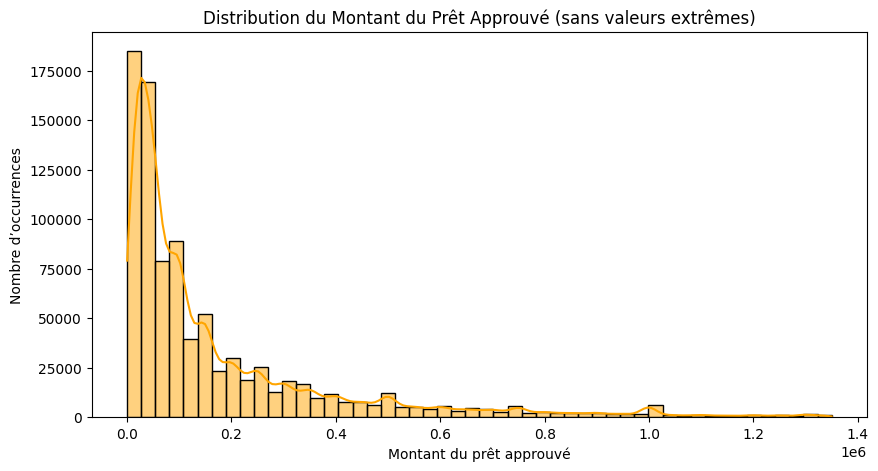

In [42]:
plt.figure(figsize=(10, 5))

# Définir une limite en fonction du 99e percentile
upper_limit = df2['GrAppv'].quantile(0.99)
sns.histplot(df2[df2['GrAppv'] < upper_limit]['GrAppv'], bins=50, kde=True, color='orange')

plt.title('Distribution du Montant du Prêt Approuvé (sans valeurs extrêmes)')
plt.xlabel('Montant du prêt approuvé')
plt.ylabel('Nombre d’occurrences')

plt.show()


In [43]:
import plotly.express as px

fig = px.histogram(df2,
                    x='Term',
                    marginal='box',
                    color='MIS_Status',
                    color_discrete_sequence=['green', 'orange'],
                    title="Distribution des charges")

fig.update_layout(bargap=0.1)
fig.show() 

In [44]:
df2.head()

Term  FranchiseCode State BankState NAICS_2  NoEmp  NewExist  RetainedJob  \
0    84              1    IN        OH      45      4       2.0            0   
1    60              1    IN        IN      72      2       2.0            0   
2   180              1    IN        IN      62      7       1.0            0   
3    60              1    OK        OK       0      2       1.0            0   
4   240              1    FL        FL       0     14       1.0            7   

   CreateJob  UrbanRural  RevLineCr  ApprovalFY  DisbursementGross    GrAppv  \
0          0           0        0.0        1997            60000.0   60000.0   
1          0           0        0.0        1997            40000.0   40000.0   
2          0           0        0.0        1997           287000.0  287000.0   
3          0           0        0.0        1997            35000.0   35000.0   
4          7           0        0.0        1997           229000.0  229000.0   

   LowDoc  MIS_Status  
0     1.0         1.0  
1     1.0         1.0  
2     0.0         1.0  
3     1.0         1.0  
4     0.0         1.0

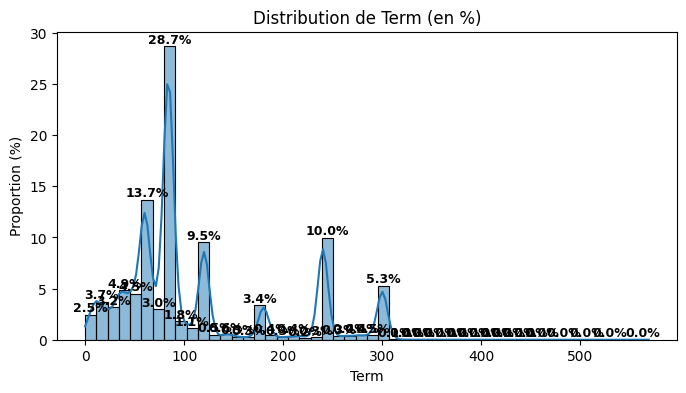

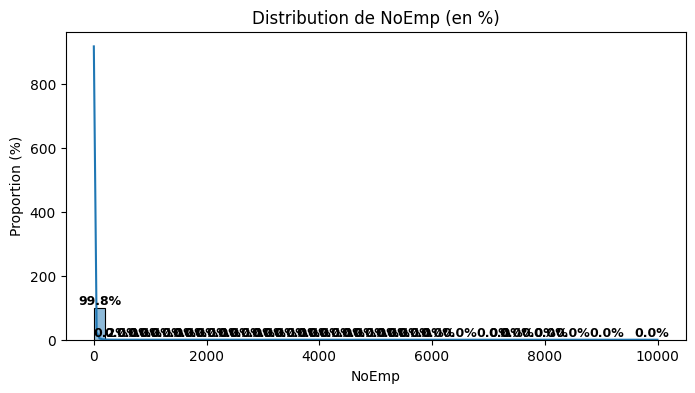

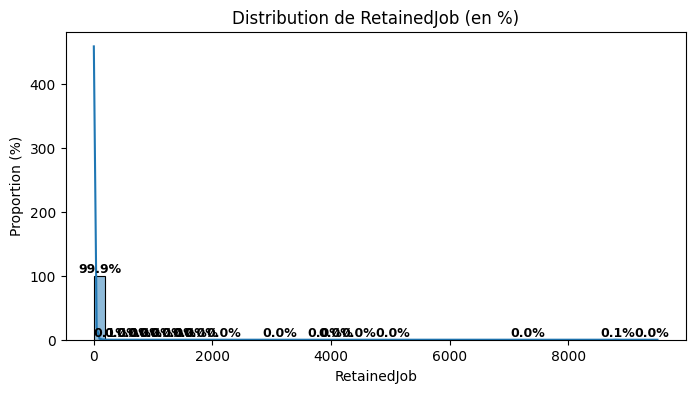

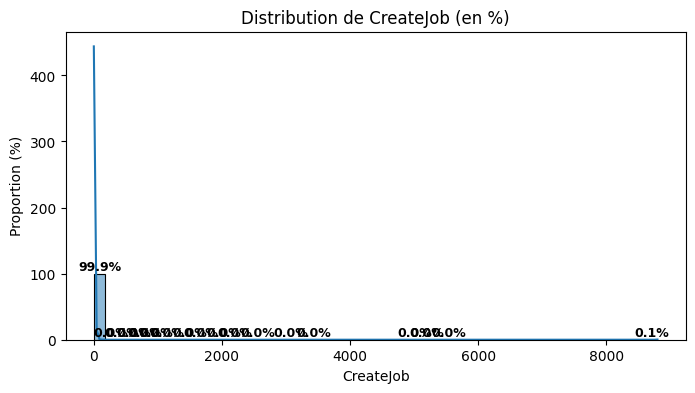

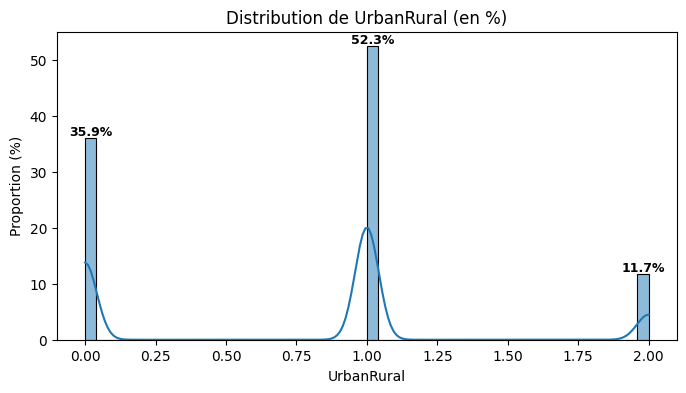

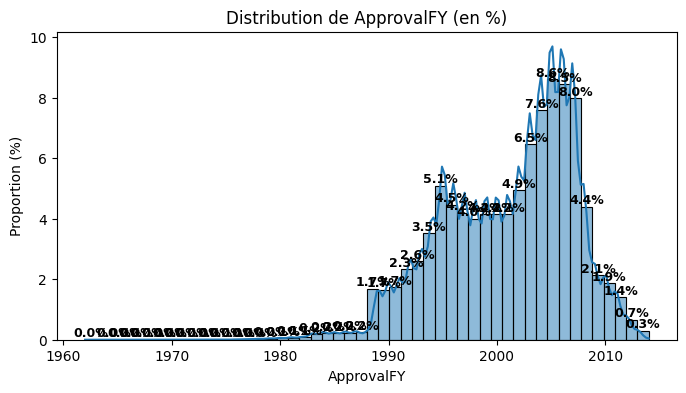

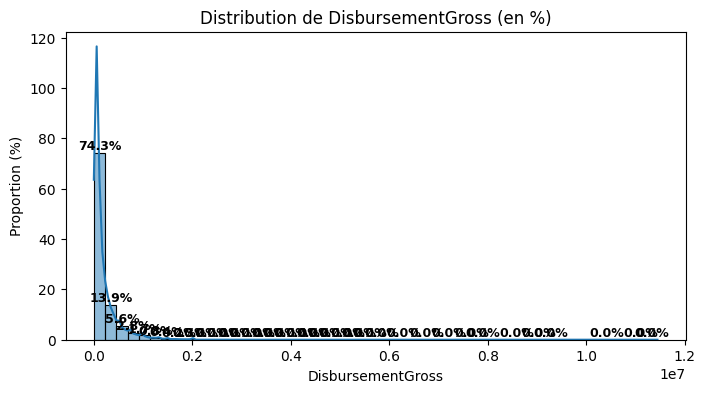

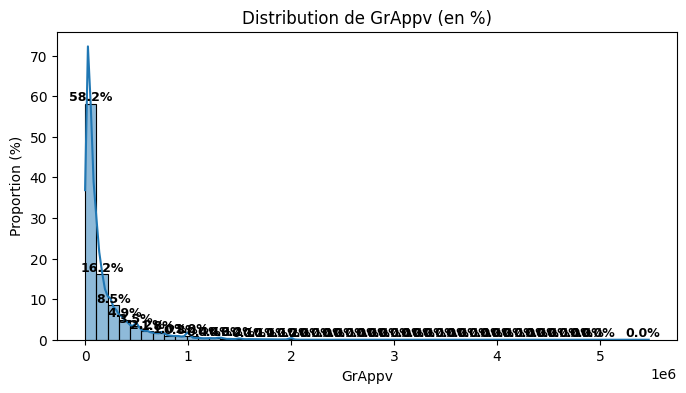

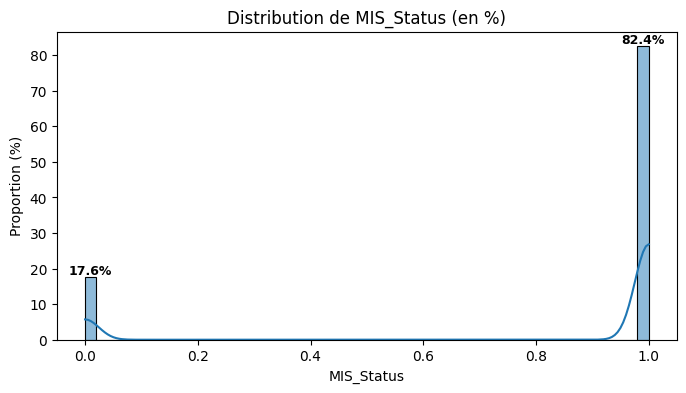

In [45]:
# Liste des variables numériques
num_vars = ['Term', 'NoEmp', 'RetainedJob', 'CreateJob', 'UrbanRural', 'ApprovalFY', 'DisbursementGross', 'GrAppv', 'MIS_Status']

for var in num_vars:
    plt.figure(figsize=(8, 4))

    # Histogramme avec proportions
    ax = sns.histplot(df2[var], bins=50, kde=True, stat="percent")  # Affichage en pourcentage
    
    # Ajouter les valeurs en texte sur les barres
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Éviter d'afficher des labels inutiles
            ax.annotate(f'{height:.1f}%',  # Affichage en pourcentage
                        (p.get_x() + p.get_width() / 2., height),  
                        ha='center', va='bottom', fontsize=9, color='black', fontweight='bold')

    plt.title(f'Distribution de {var} (en %)')
    plt.ylabel('Proportion (%)')
    plt.xlabel(var)
    plt.show()


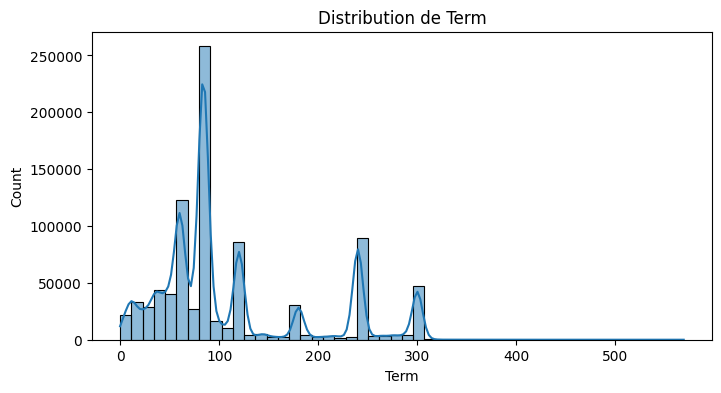

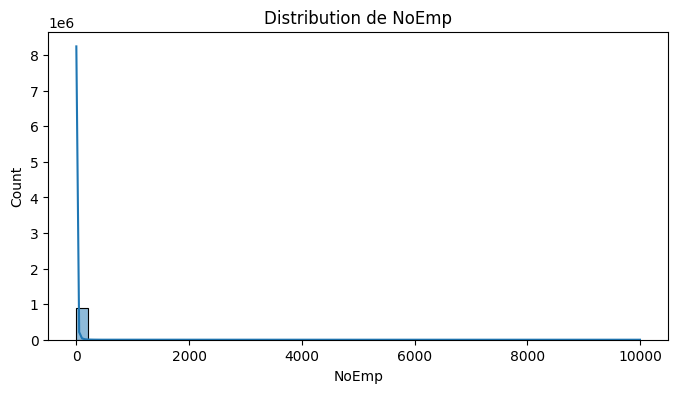

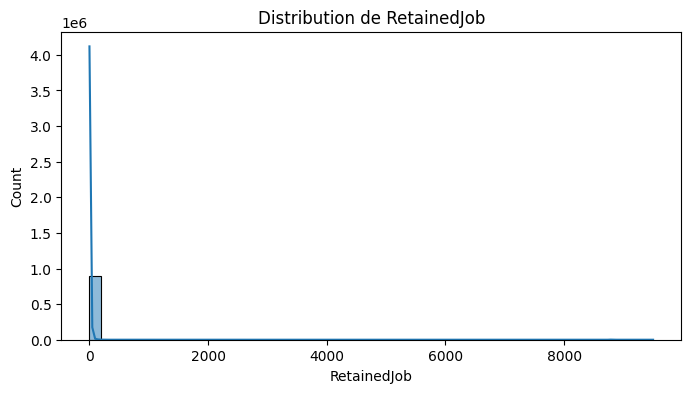

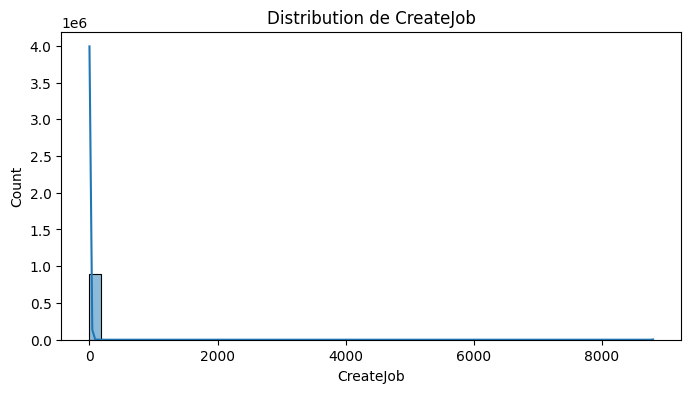

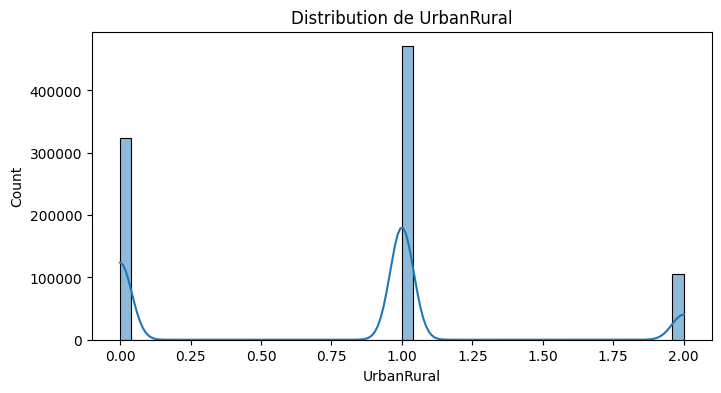

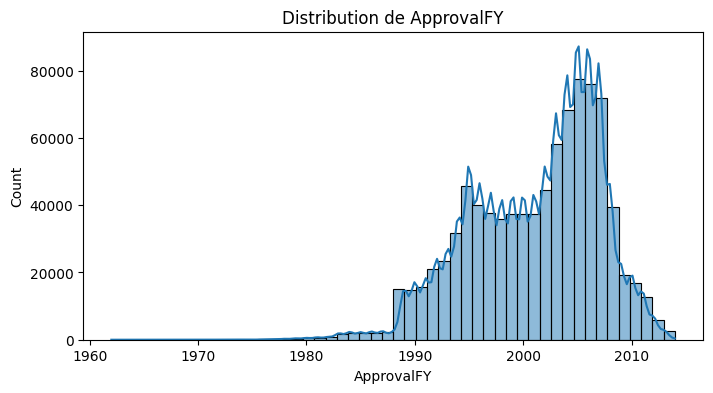

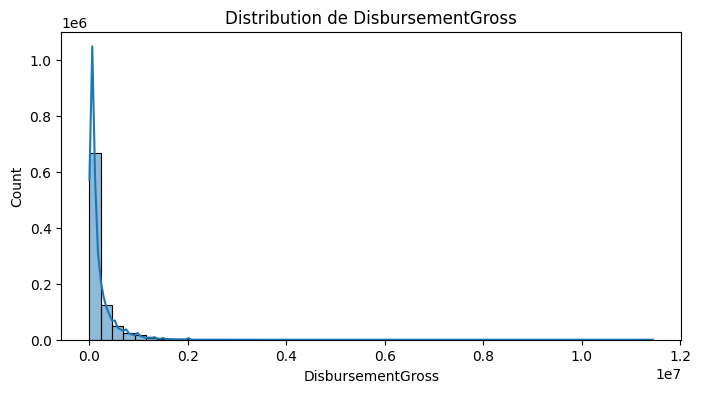

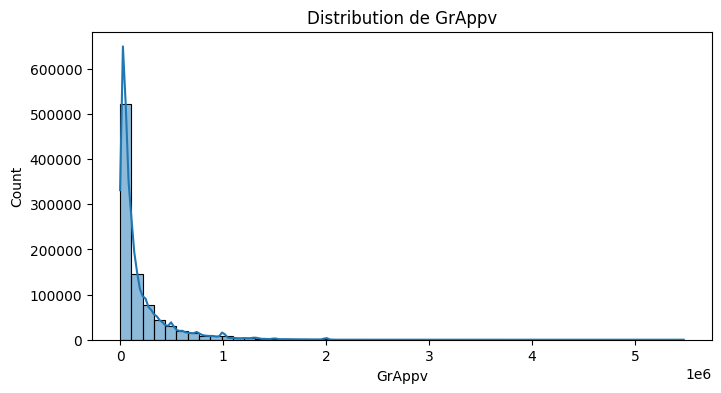

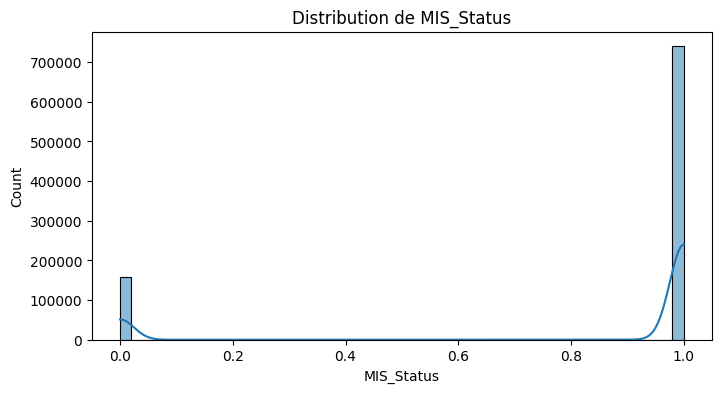

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des variables numériques
num_vars = ['Term', 'NoEmp', 'RetainedJob', 'CreateJob', 'UrbanRural', 'ApprovalFY', 'DisbursementGross', 'GrAppv','MIS_Status']

# Histogrammes pour chaque variable
for var in num_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(df2[var], bins=50, kde=True)
    plt.title(f'Distribution de {var}')
    plt.show()


- Variable Catégorie

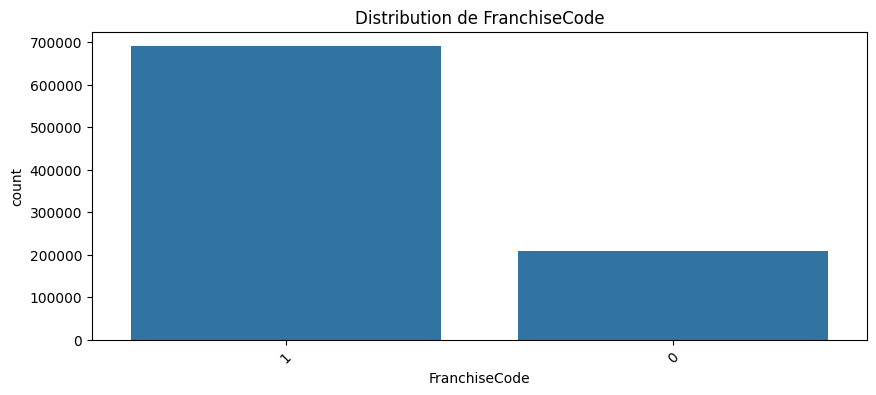

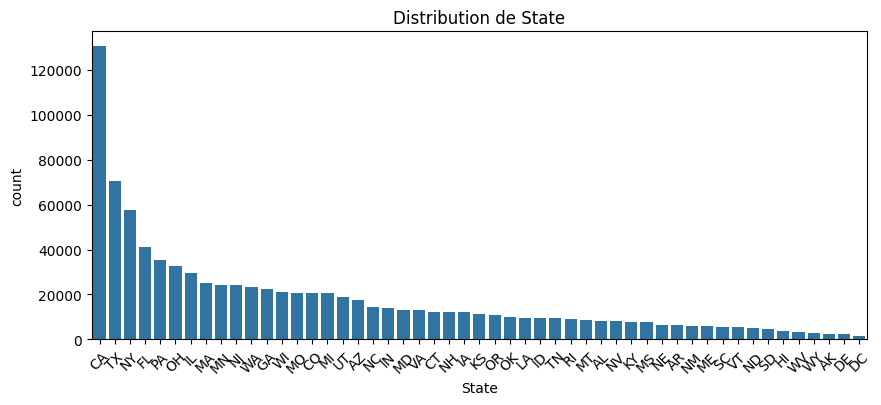

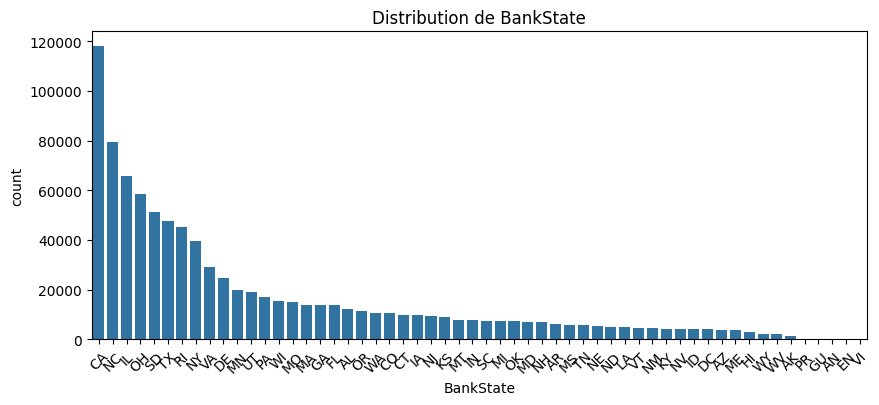

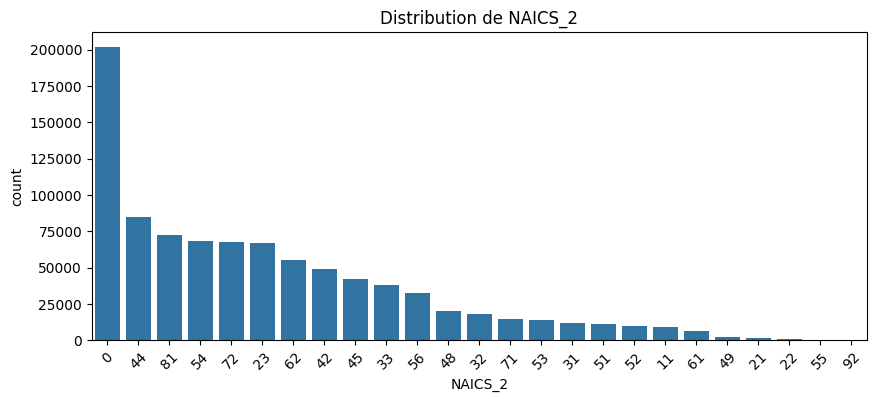

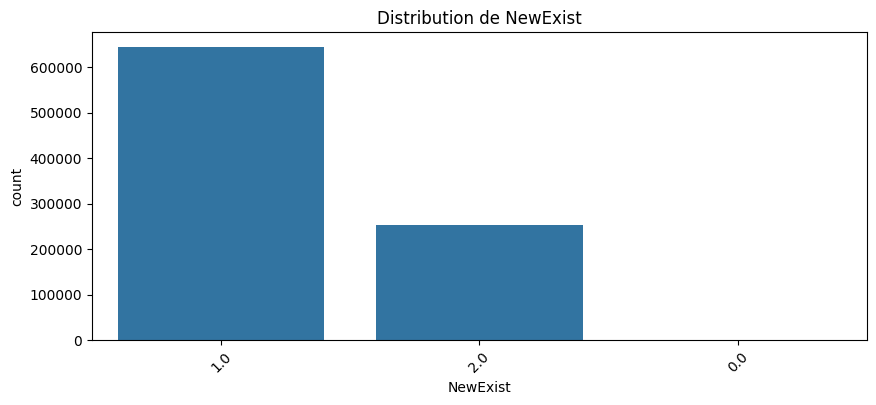

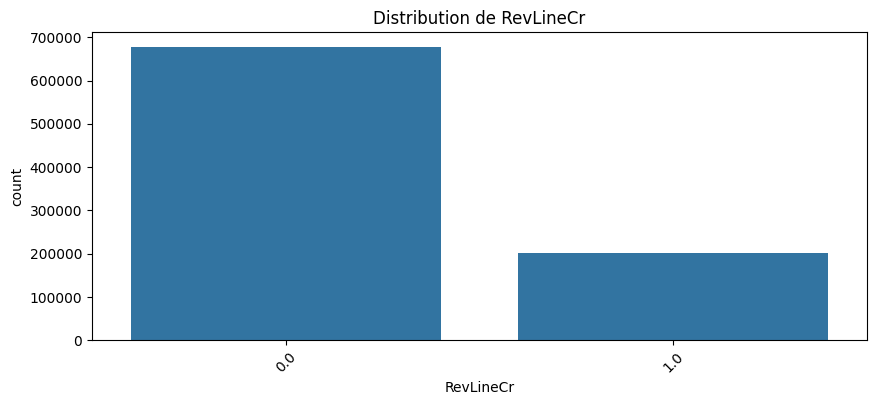

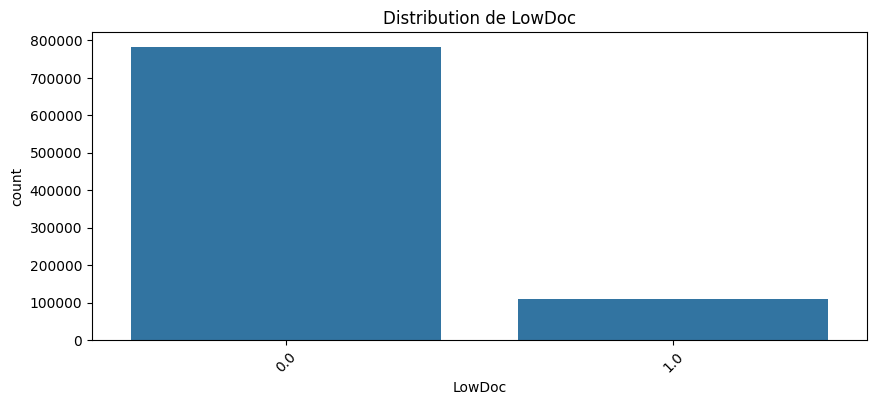

In [47]:
cat_vars = ['FranchiseCode', 'State', 'BankState', 'NAICS_2', 'NewExist', 'RevLineCr', 'LowDoc']

for var in cat_vars:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=df2[var], order=df2[var].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f'Distribution de {var}')
    plt.show()


- Analyse bivariable

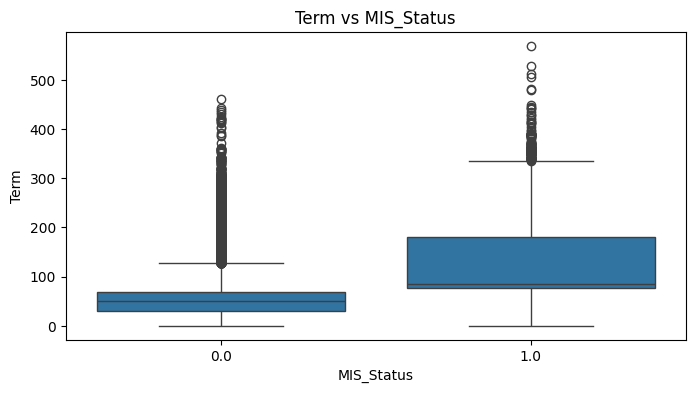

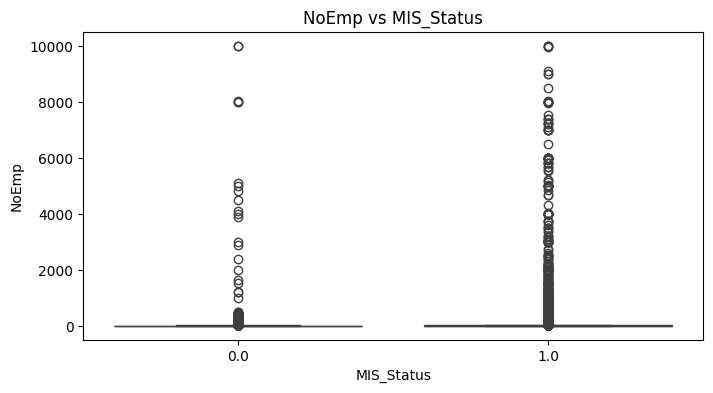

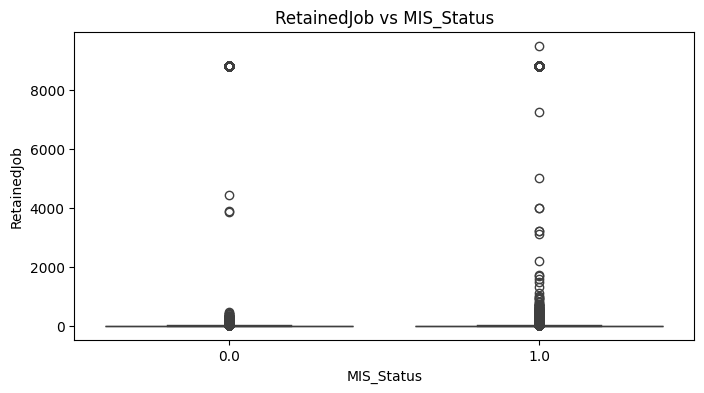

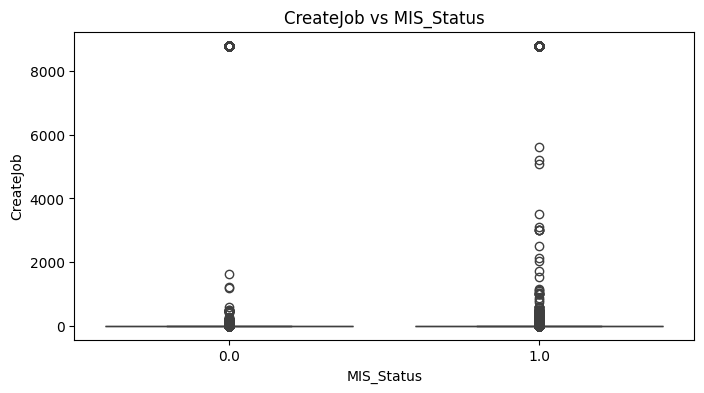

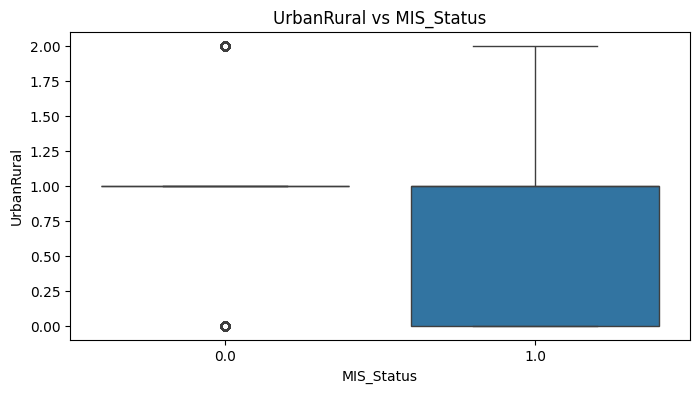

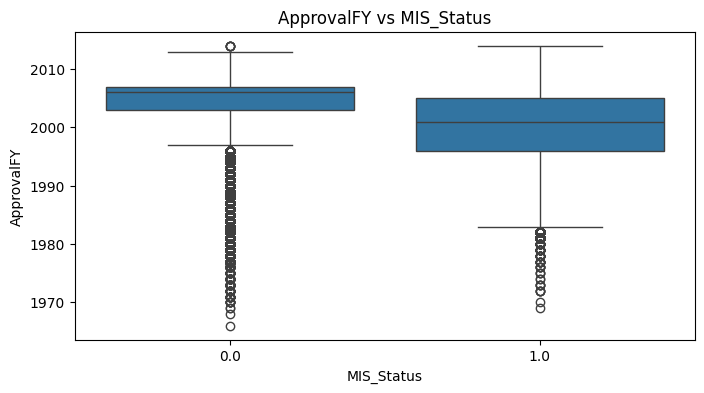

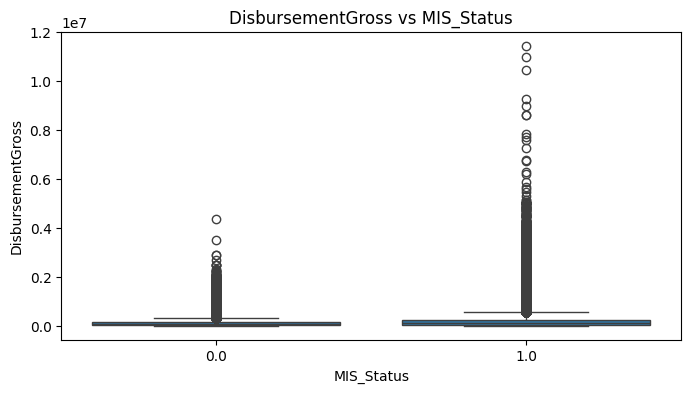

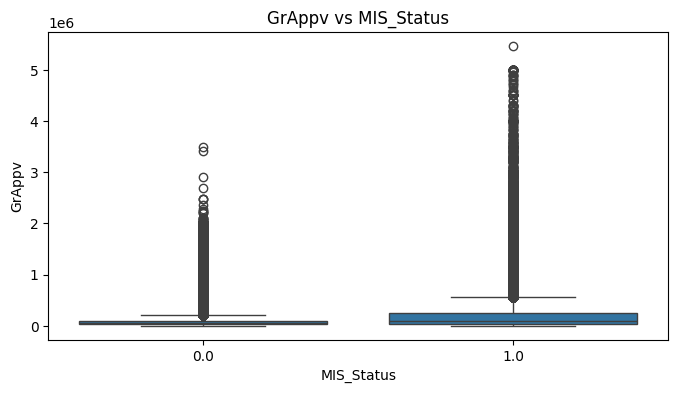

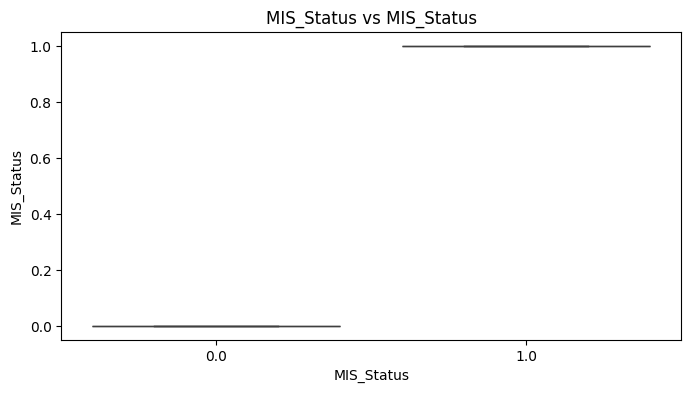

In [48]:
for var in num_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x='MIS_Status', y=var, data=df2)
    plt.title(f'{var} vs MIS_Status')
    plt.show()


Variables catégorielles vs MIS_Status

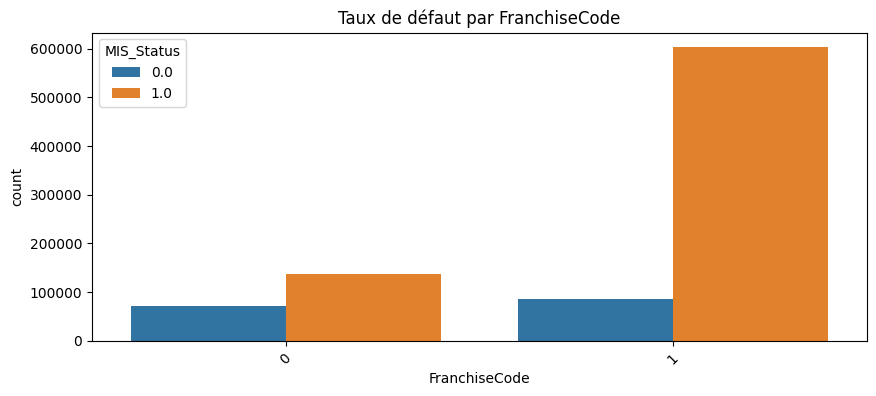

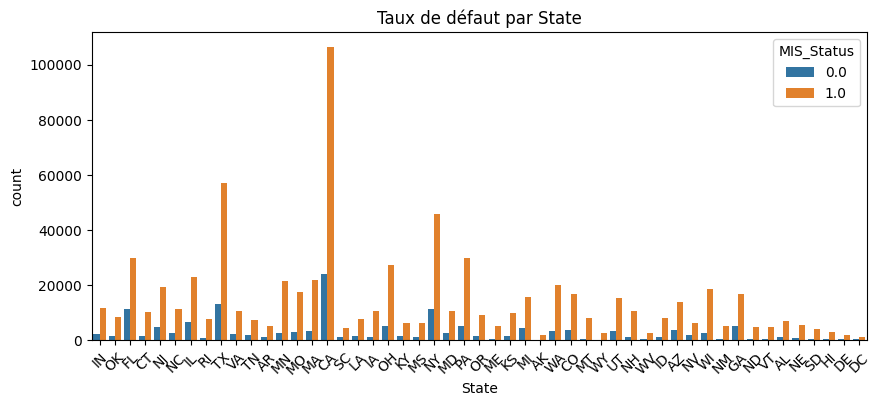

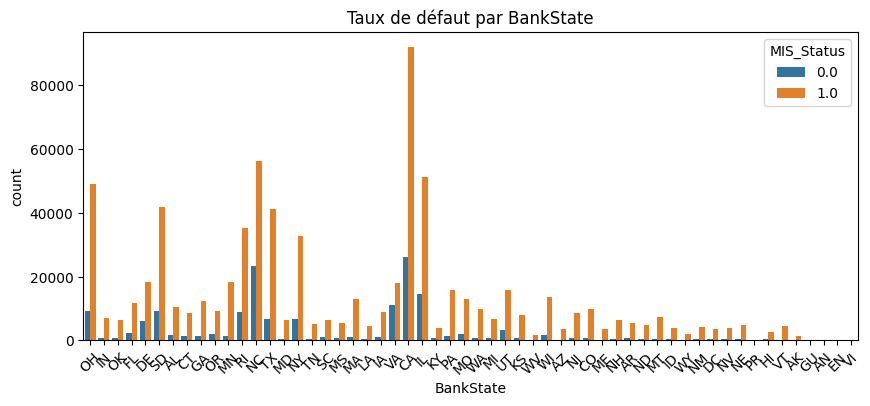

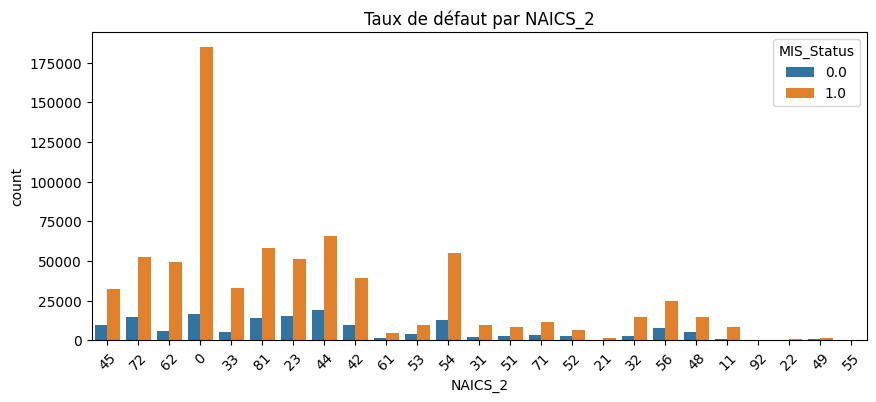

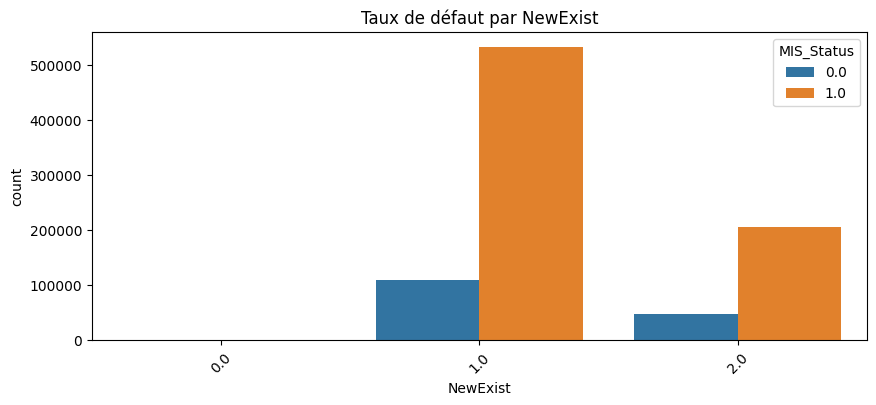

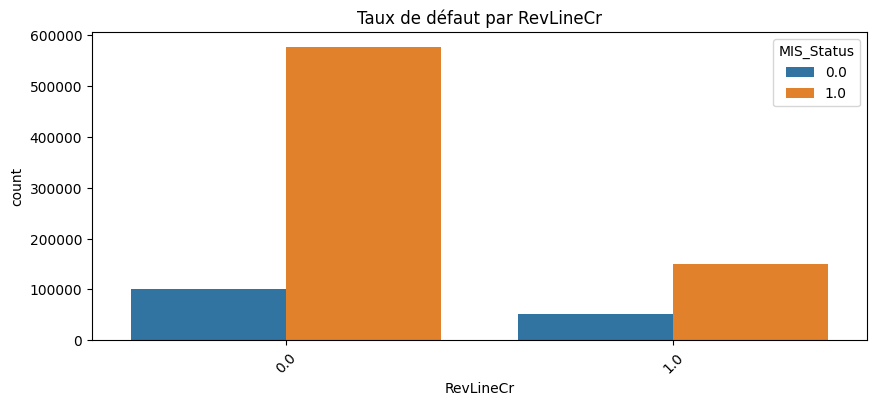

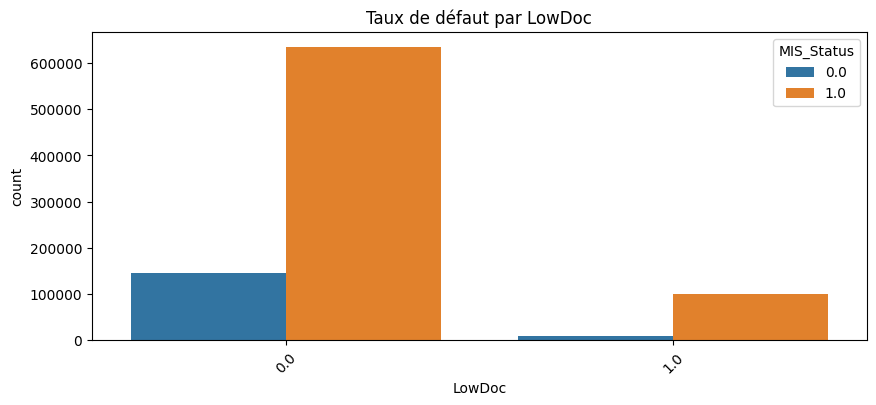

In [49]:
for var in cat_vars:
    plt.figure(figsize=(10, 4))
    sns.countplot(x=df2[var], hue=df2['MIS_Status'])
    plt.xticks(rotation=45)
    plt.title(f'Taux de défaut par {var}')
    plt.show()


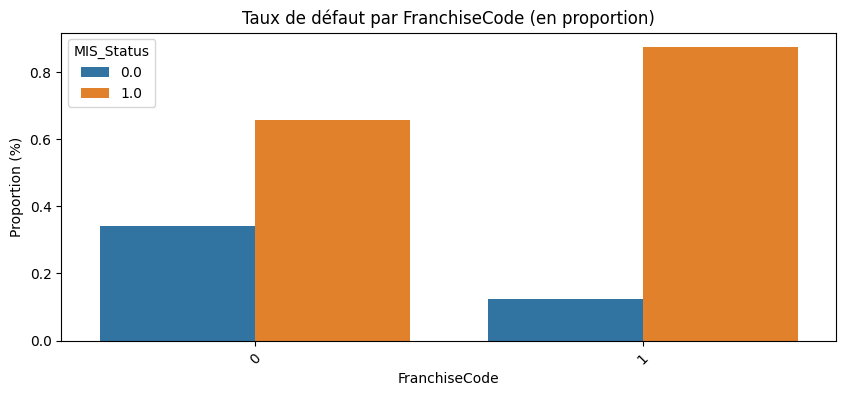

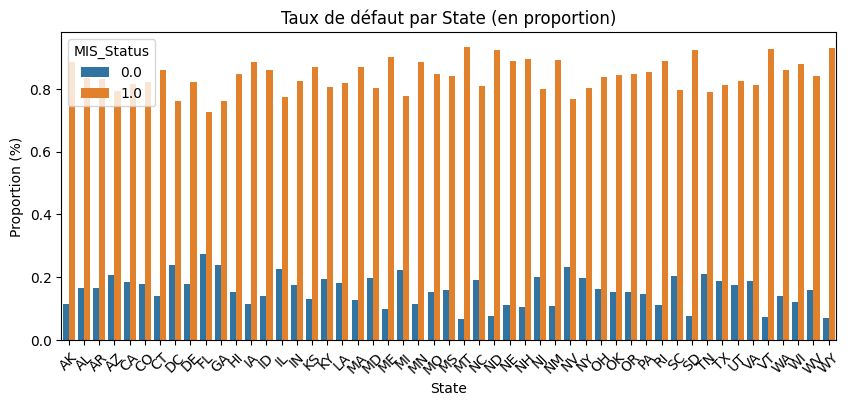

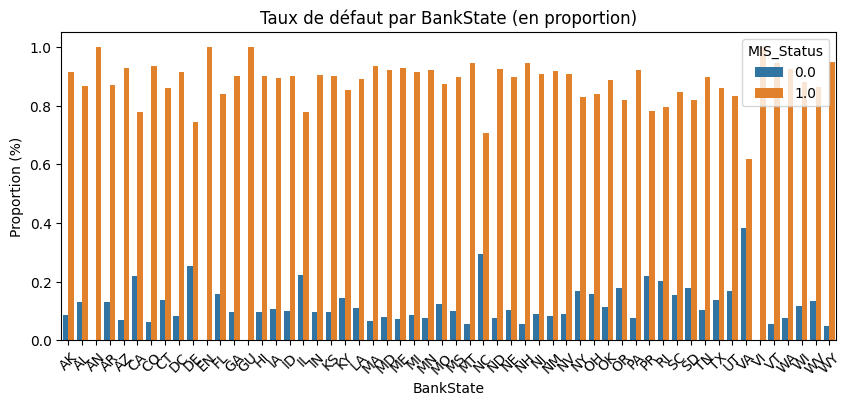

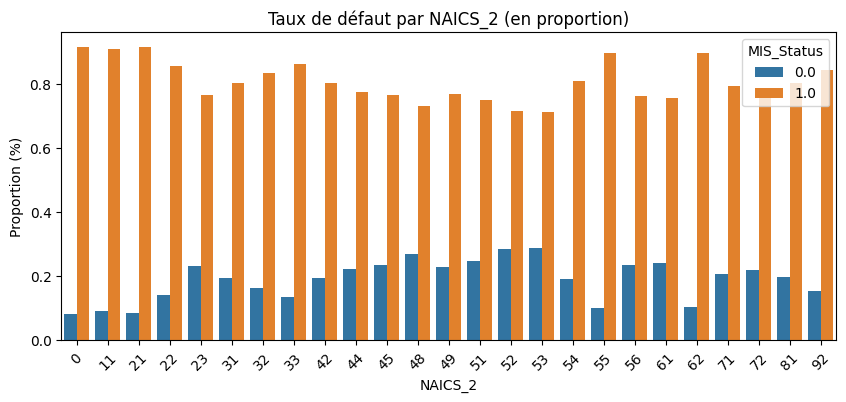

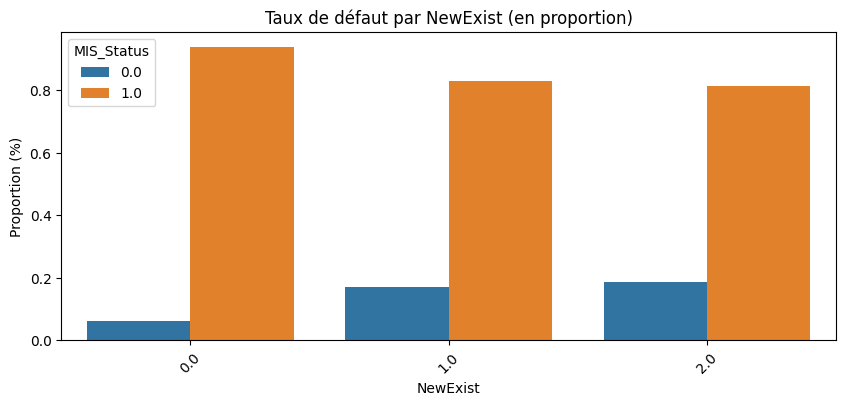

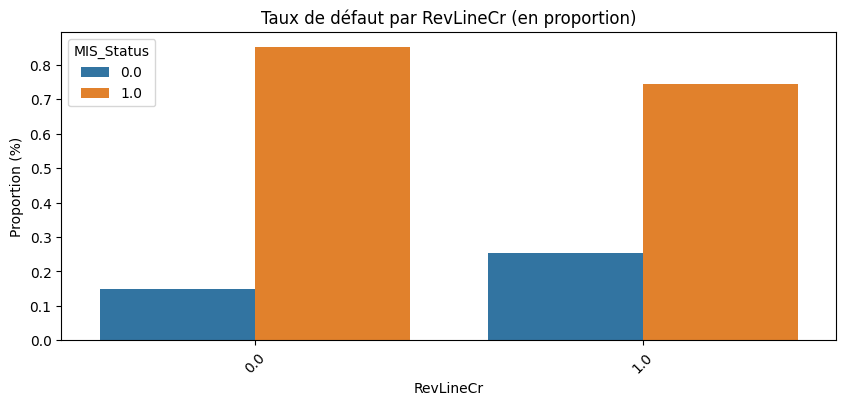

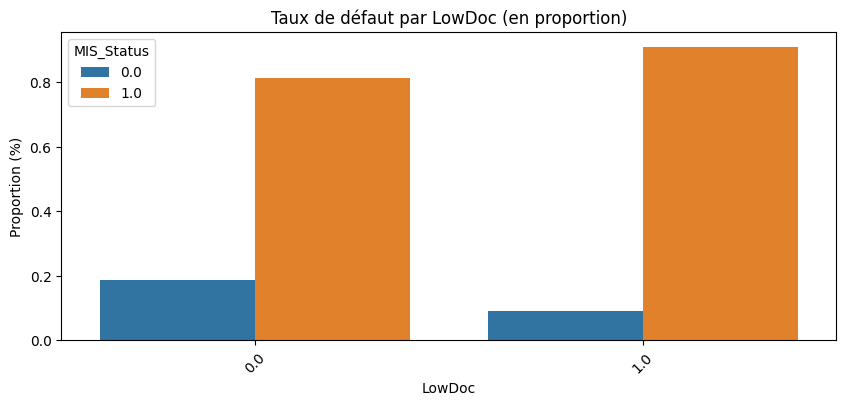

In [50]:
cat_vars = ['FranchiseCode', 'State', 'BankState', 'NAICS_2', 'NewExist', 'RevLineCr', 'LowDoc']

for var in cat_vars:
    plt.figure(figsize=(10, 4))

    # Calculer les proportions
    df_grouped = df2.groupby([var, 'MIS_Status']).size().reset_index(name='count')
    df_grouped['proportion'] = df_grouped.groupby(var)['count'].transform(lambda x: x / x.sum())

    # Création du graphique
    sns.barplot(x=var, y='proportion', hue='MIS_Status', data=df_grouped)

    plt.xticks(rotation=45)
    plt.title(f'Taux de défaut par {var} (en proportion)')
    plt.ylabel('Proportion (%)')
    plt.show()

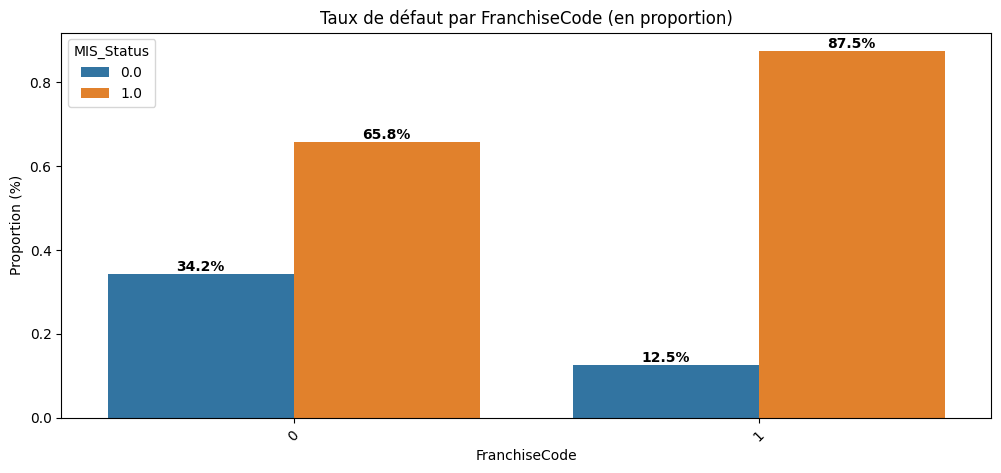

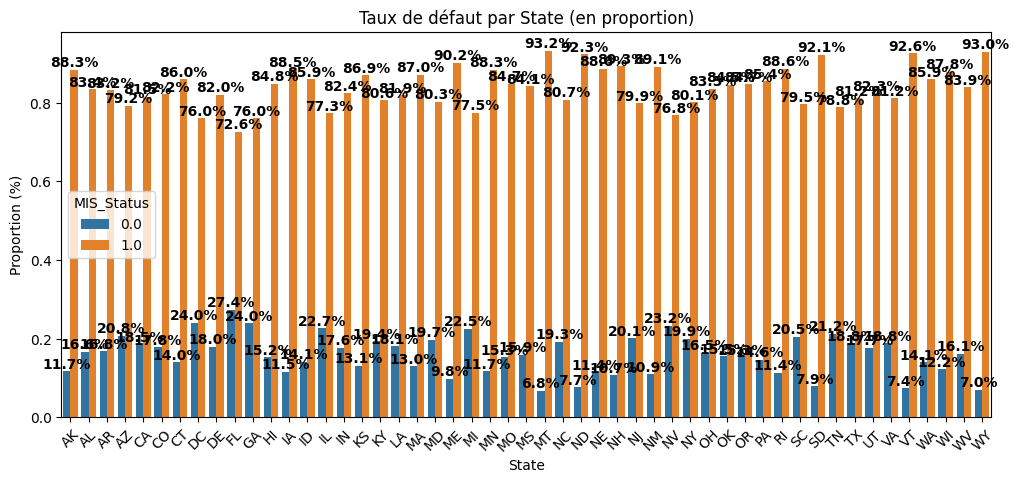

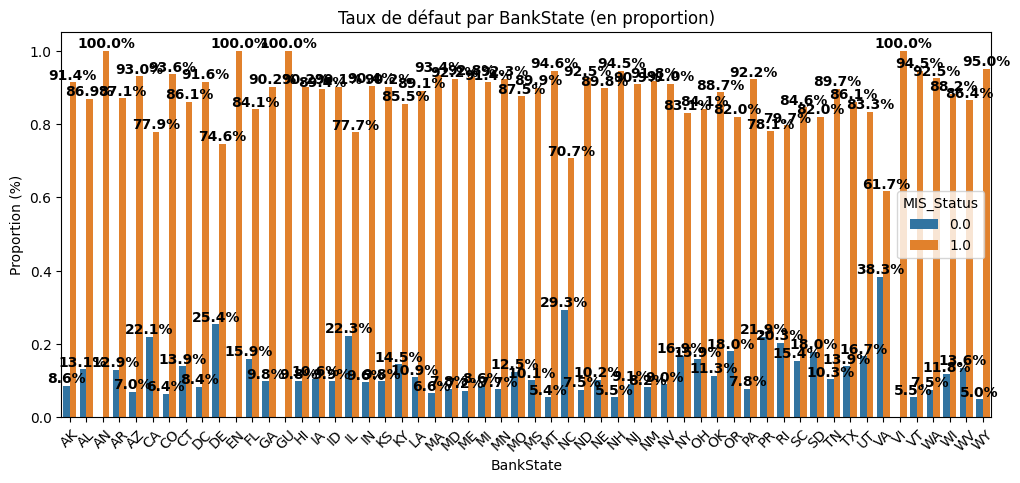

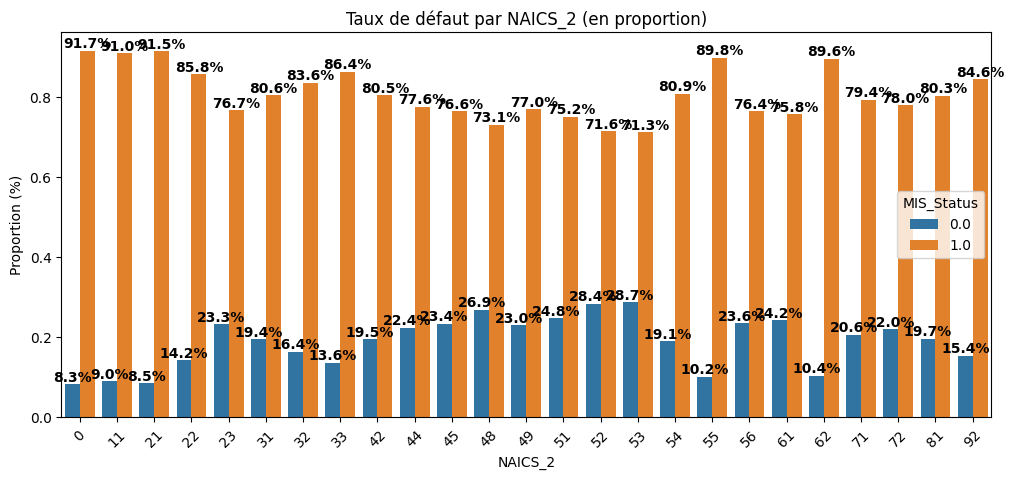

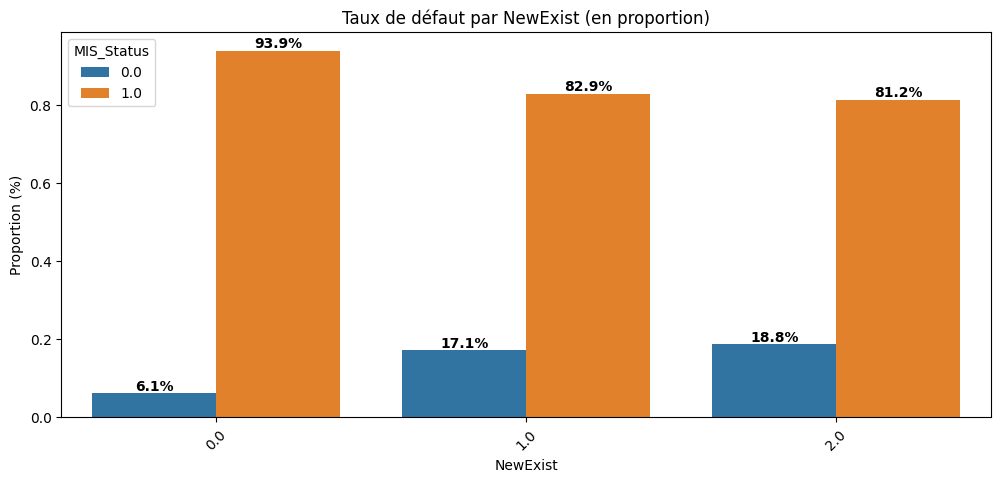

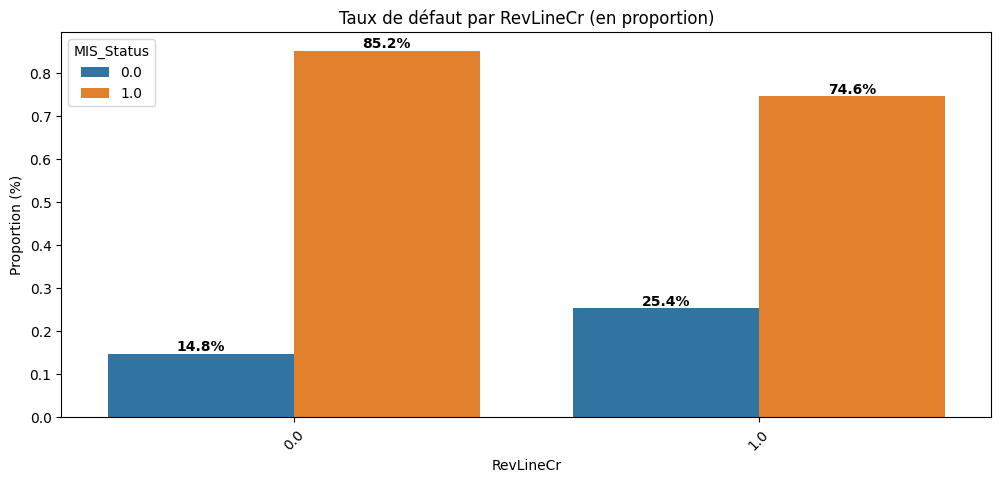

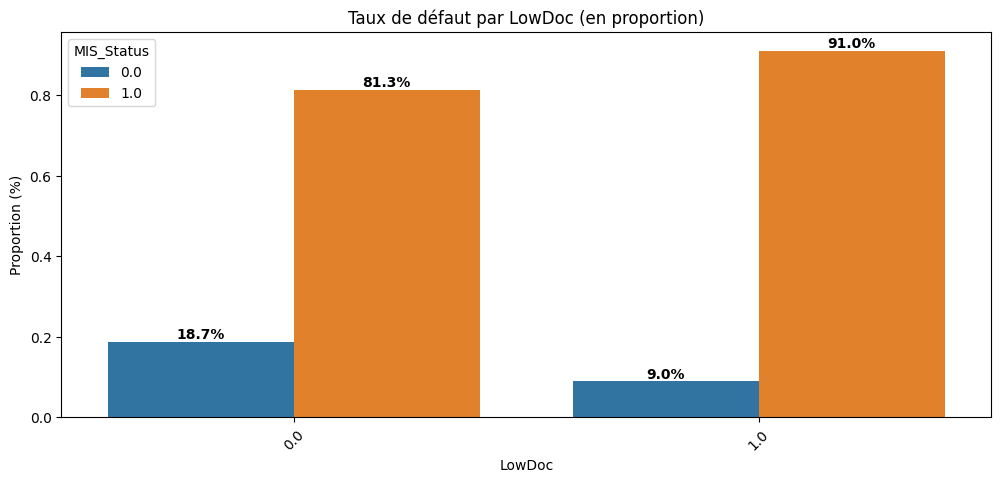

In [51]:
cat_vars = ['FranchiseCode', 'State', 'BankState', 'NAICS_2', 'NewExist', 'RevLineCr', 'LowDoc']

for var in cat_vars:
    plt.figure(figsize=(12, 5))

    # Calculer les proportions
    df_grouped = df2.groupby([var, 'MIS_Status']).size().reset_index(name='count')
    df_grouped['proportion'] = df_grouped.groupby(var)['count'].transform(lambda x: x / x.sum())

    # Création du graphique
    ax = sns.barplot(x=var, y='proportion', hue='MIS_Status', data=df_grouped)
    
    # Ajouter les proportions en texte sur les barres
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  # Pour éviter d'afficher des labels inutiles
            ax.annotate(f'{height:.1%}',  
                        (p.get_x() + p.get_width() / 2., height),  
                        ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

    plt.xticks(rotation=45)
    plt.title(f'Taux de défaut par {var} (en proportion)')
    plt.ylabel('Proportion (%)')
    plt.xlabel(var)
    plt.show()


- Analyse Multivariable (Corrélations entre plusieurs variables)

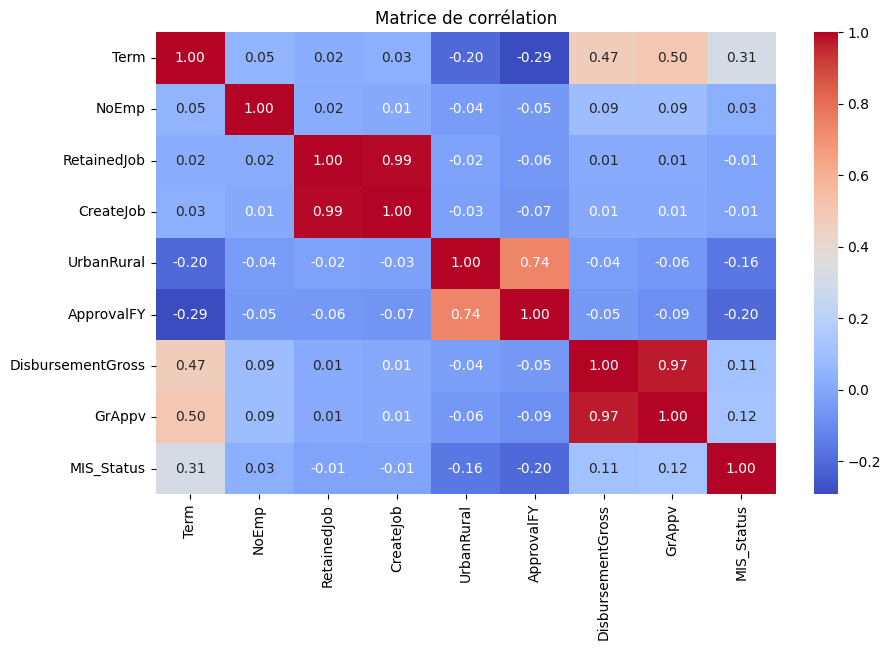

In [52]:
import numpy as np

# Calcul de la matrice de corrélation
corr = df2[num_vars].corr()

# Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matrice de corrélation")
plt.show()


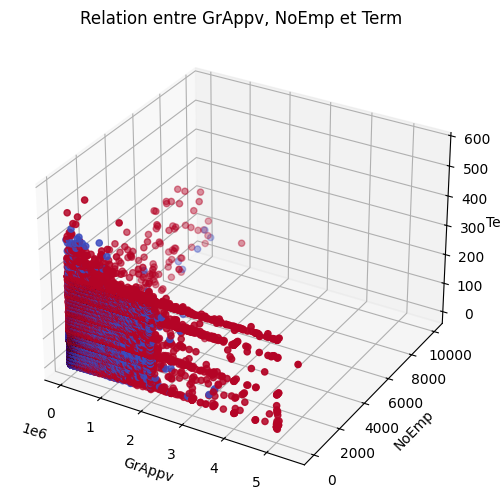

In [53]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df2['GrAppv'], df2['NoEmp'], df2['Term'], c=df2['MIS_Status'], cmap='coolwarm')
ax.set_xlabel('GrAppv')
ax.set_ylabel('NoEmp')
ax.set_zlabel('Term')
plt.title('Relation entre GrAppv, NoEmp et Term')
plt.show()


In [54]:
df2.describe()

Term  FranchiseCode          NoEmp       NewExist  \
count  899164.000000  899164.000000  899164.000000  899028.000000   
mean      110.773078       0.767745      11.411353       1.280404   
std        78.857305       0.422271      74.108196       0.451750   
min         0.000000       0.000000       0.000000       0.000000   
25%        60.000000       1.000000       2.000000       1.000000   
50%        84.000000       1.000000       4.000000       1.000000   
75%       120.000000       1.000000      10.000000       2.000000   
max       569.000000       1.000000    9999.000000       2.000000   

         RetainedJob      CreateJob     UrbanRural      RevLineCr  ApprovalFY  \
count  899164.000000  899164.000000  899164.000000  879310.000000    899164.0   
mean       10.797257       8.430376       0.757748       0.229066  2001.14356   
std       237.120600     236.688165       0.646436       0.420232    5.913846   
min         0.000000       0.000000       0.000000       0.000000      1962.0   
25%         0.000000       0.000000       0.000000       0.000000      1997.0   
50%         1.000000       0.000000       1.000000       0.000000      2002.0   
75%         4.000000       1.000000       1.000000       0.000000      2006.0   
max      9500.000000    8800.000000       2.000000       1.000000      2014.0   

       DisbursementGross        GrAppv         LowDoc     MIS_Status  
count       8.991640e+05  8.991640e+05  893157.000000  897167.000000  
mean        2.011540e+05  1.926870e+05       0.123534       0.824383  
std         2.876408e+05  2.832634e+05       0.329049       0.380494  
min         0.000000e+00  2.000000e+02       0.000000       0.000000  
25%         4.200000e+04  3.500000e+04       0.000000       1.000000  
50%         1.000000e+05  9.000000e+04       0.000000       1.000000  
75%         2.380000e+05  2.250000e+05       0.000000       1.000000  
max         1.144632e+07  5.472000e+06       1.000000       1.000000

In [55]:
df2.isna().sum()

Term                     0
FranchiseCode            0
State                   14
BankState             1566
NAICS_2                  0
NoEmp                    0
NewExist               136
RetainedJob              0
CreateJob                0
UrbanRural               0
RevLineCr            19854
ApprovalFY               0
DisbursementGross        0
GrAppv                   0
LowDoc                6007
MIS_Status            1997
dtype: int64

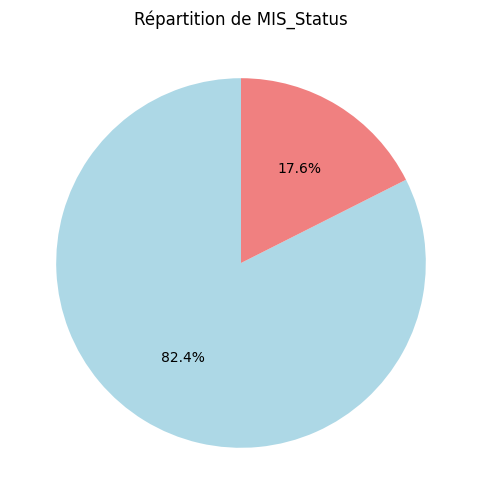

In [56]:
# Création du camembert
plt.figure(figsize=(6, 6))
plt.pie(df['MIS_Status'].value_counts(), autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])

# Ajouter un titre
plt.title("Répartition de MIS_Status")

# Afficher le graphique
plt.show()

In [57]:
df2.to_csv("preparation_data.csv", index=False)